Medical Insurance Price Prediction

Task 1 : Import the dataset

In [285]:
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [286]:
df = pd.read_csv('/Users/sherzod19/Downloads/Medical_insurance.csv', header=None)
df.head()

,0,1,2,3,4,5,6
0,age,sex,bmi,children,smoker,region,charges
1,19,female,27.9,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.5523
3,28,male,33,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.47061


In [287]:
headers = ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns = headers

In [288]:
df.head(10)

,age,gender,bmi,no_of_children,smoker,region,charges
0,age,sex,bmi,children,smoker,region,charges
1,19,female,27.9,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.5523
3,28,male,33,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.47061
5,32,male,28.88,0,no,northwest,3866.8552
6,31,female,25.74,0,no,southeast,3756.6216
7,46,female,33.44,1,no,southeast,8240.5896
8,37,female,27.74,3,no,northwest,7281.5056
9,37,male,29.83,2,no,northeast,6406.4107


In [289]:
df = df.drop(0)
df.head()


,age,gender,bmi,no_of_children,smoker,region,charges
1,19,female,27.9,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.5523
3,28,male,33,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.47061
5,32,male,28.88,0,no,northwest,3866.8552


In [290]:
# Replace '?' with actual NaN
df.replace('?', pd.NA, inplace=True)

# Then you can use proper NA detection
df.isna()

,age,gender,bmi,no_of_children,smoker,region,charges
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
2768,False,False,False,False,False,False,False
2769,False,False,False,False,False,False,False
2770,False,False,False,False,False,False,False
2771,False,False,False,False,False,False,False


Task 2 : Data Wrangling

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 1 to 2772
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             2772 non-null   object
 1   gender          2772 non-null   object
 2   bmi             2772 non-null   object
 3   no_of_children  2772 non-null   object
 4   smoker          2772 non-null   object
 5   region          2772 non-null   object
 6   charges         2772 non-null   object
dtypes: object(7)
memory usage: 151.7+ KB


In [292]:
df['age'] = df['age'].astype('int')
df['bmi'] = df['bmi'].astype('float')
df['charges'] = df['charges'].astype('float')

In [293]:
mean_age = df['age'].mean()
df['age'].replace(np.nan, mean_age)
df['age'].isnull()


1       False
2       False
3       False
4       False
5       False
        ...  
2768    False
2769    False
2770    False
2771    False
2772    False
Name: age, Length: 2772, dtype: bool

In [294]:
frequent_smoker = df['smoker'].value_counts().idxmax()
df['smoker'].replace(np.nan, frequent_smoker, inplace=True)
df['smoker'].isnull()

/var/folders/ft/t6sg9z_s0s36_hp9lkf9y08w0000gn/T/ipykernel_1941/61792701.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['smoker'].replace(np.nan, frequent_smoker, inplace=True)


1       False
2       False
3       False
4       False
5       False
        ...  
2768    False
2769    False
2770    False
2771    False
2772    False
Name: smoker, Length: 2772, dtype: bool

In [295]:
df['charges'] =df['charges'].round(2)
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
1,19,female,27.900,0,yes,southwest,16884.92
2,18,male,33.770,1,no,southeast,1725.55
3,28,male,33.000,3,no,southeast,4449.46
4,33,male,22.705,0,no,northwest,21984.47
5,32,male,28.880,0,no,northwest,3866.86


Task 3 : Exploratory Data Analysis (EDA)

(0.0, 66902.85800000001)

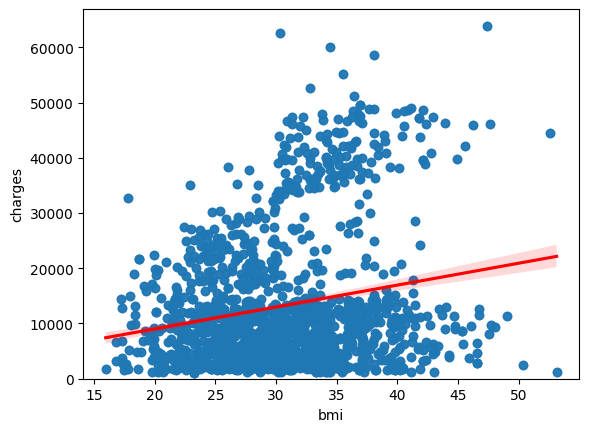

In [296]:
sns.regplot(data=df, y='charges', x='bmi', line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='smoker', ylabel='charges'>

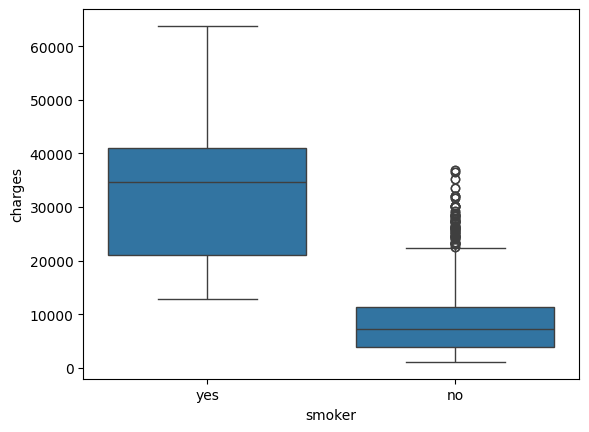

In [297]:
sns.boxplot(data=df, x='smoker', y='charges')


In [298]:
df.corr(numeric_only=True)

,age,bmi,charges
age,1.000000,0.113048,0.298624
bmi,0.113048,1.000000,0.199846
charges,0.298624,0.199846,1.000000


Task 4 : Model Development

In [299]:
df['smoker_numeric'] = df['smoker'].map({'yes': 1, 'no': 0})
X = df[['smoker_numeric']]
Y = df[['charges']]
ml = LinearRegression()
ml.fit(X, Y)
ml.score(X, Y)

0.6221791733924185

In [300]:
Z = pd.get_dummies(df.drop("charges", axis=1), drop_first=True)
Y1 = df['charges']
ml.fit(Z, Y1)
ml.score(Z, Y1)

0.7522041335489578

In [301]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('polynomial', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression())
])
Z = Z.astype(float)
pipe.fit(Z, Y1)
ypipe = pipe.predict(Z)
r2_score(Y, ypipe)


0.8523669849386394

Task 5 : Model Refinement

In [308]:
x_train, x_test, y_train, y_test = train_test_split(Z, Y1, test_size=0.2, random_state=0)
print('number of test samples:', x_test.shape[0])
print('number of training samples:', x_train.shape[0])

number of test samples: 555
number of training samples: 2217


In [309]:
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yhat = RidgeModel.predict(x_test)
print(r2_score(y_test,yhat))

0.7469942502357799


In [310]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.transform(x_test)
RidgeModel.fit(x_train_pr, y_train)
y_hat = RidgeModel.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.8418774968781185
